In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.parquet', 'sample_submission.csv', 'metadata_train.csv', 'train.parquet', 'metadata_test.csv']


In [2]:
#!pip install fastparquet
#from fastparquet import ParquetFile
import pyarrow.parquet as pq
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import gc
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.utils import *
import keras.backend as K

Using TensorFlow backend.


In [3]:
#id_measurement: the ID code for a trio of signals recorded at the same time.
#signal_id: the foreign key for the signal data. Each signal ID is unique across both train and test,
#so the first ID in train is '0' but the first ID in test is '8712'.
#phase: the phase ID code within the signal trio. The phases may or may not all be impacted by a fault on the line.
#target: 0 if the power line is undamaged, 1 if there is a fault.
#From the Pictures Below , Found that this is imbalanced data.

Text(0.5,1,'the number of target in different phase')

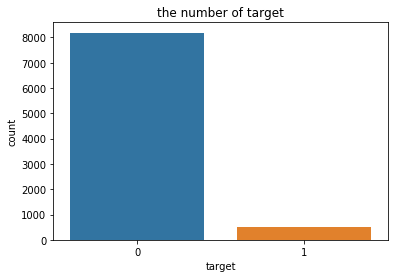

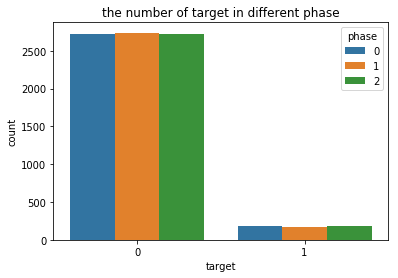

In [4]:
m_train = "../input/metadata_train.csv"
par_train = "../input/train.parquet"

meta_train = pd.read_csv(m_train)
meta_train = meta_train.set_index('id_measurement')
#print(meta_train.head(9))
plt.figure()
sns.countplot(x='target', data=meta_train) 
plt.title('the number of target')
plt.figure()
sns.countplot(x='target', hue='phase', data=meta_train)
plt.title('the number of target in different phase')

In [5]:
#The signal data. Each column contains one signal; 800,000 int8 measurements as exported with
pf_train = pq.read_pandas(par_train)
pf_train = pf_train.to_pandas()
pf_train = pf_train.T 

#print(pf_train.head())

In [6]:
#Because of Out of memory 
pf_train_v = pf_train.values

del pf_train
gc.collect()

8733

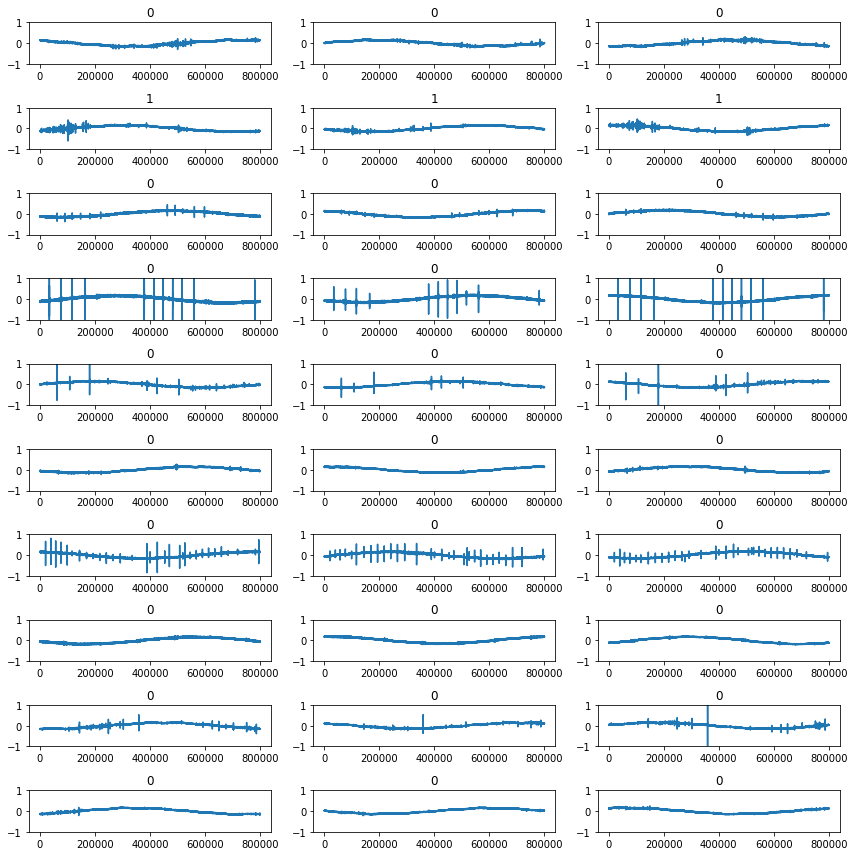

In [7]:
#Normalize Data, change Data to (-1,1)
def min_max(x, min=-128, max=127, range_needed=(-1, 1)):
    norm = (x+abs(min))/(max+abs(min))
    return norm * (range_needed[1] + abs(range_needed[0])) + range_needed[0]

visual_data = pf_train_v[0:30, :]
targets = meta_train.target.values[0:30]
visual_data = min_max(visual_data)

def p_fig(data, target, n_rows=None, size=120):
    assert len(target) % 3 == 0
    if n_rows == None:
        n_rows = int(len(target) / 3)        
    fig, axes = plt.subplots(n_rows, 3, figsize=(int(size/n_rows), int(size/n_rows)))
    axes = axes.flatten()
    for i, (ax, t) in enumerate(zip(axes, target)):
        ax.plot(data[i, :])
        ax.set_title(t)
        ax.set_ylim(bottom=-1.0, top=1.0)
    fig.tight_layout()

p_fig(visual_data, targets)

In [8]:
f_data = meta_train[meta_train.target == 1]
print('There are {} fault data'.format(len(f_data)))
f_signalid = f_data.signal_id.values
f_signal_data = pf_train_v[f_signalid]
f_signal_data = min_max(f_signal_data)
f_mean = np.mean(f_signal_data, axis=1, keepdims=True)
f_std = np.std(f_signal_data, axis=1, keepdims=True)

f_new_df = pd.DataFrame({'id_measurement':f_data.index.values,
                        'phase':f_data.phase.values,
                        'mean':f_mean.flatten(),
                        'std':f_std.flatten(),
                        'std_top': (f_mean+f_std).flatten(),
                        'std_bottom':(f_mean-f_std).flatten()})
del f_signal_data
gc.collect()

There are 525 fault data


51519

In [9]:
def make_mean_std(data):
    mean = []
    std = []
    for d in tqdm(data):
        d = min_max(d)
        m = d.mean()
        s = d.std()
        mean.append(m)
        std.append(s)

    return mean, std

norm_data = meta_train[meta_train.target == 0]
norm_signalid = norm_data.signal_id.values
norm_signal_data = pf_train_v[norm_signalid]
norm_mean, norm_std = make_mean_std(norm_signal_data)

100%|██████████| 8187/8187 [01:06<00:00, 123.58it/s]


In [10]:
del norm_signal_data
gc.collect()
norm_new_df = pd.DataFrame({'id_measurement':norm_data.index.values,
                            'phase':norm_data.phase.values,
                            'mean':norm_mean,
                            'std':norm_std,
                            'std_top': np.asarray(norm_mean)+np.asarray(norm_std),
                            'std_bottom': np.asarray(norm_mean)-np.asarray(norm_std),})

#print(norm_new_df.head(10))

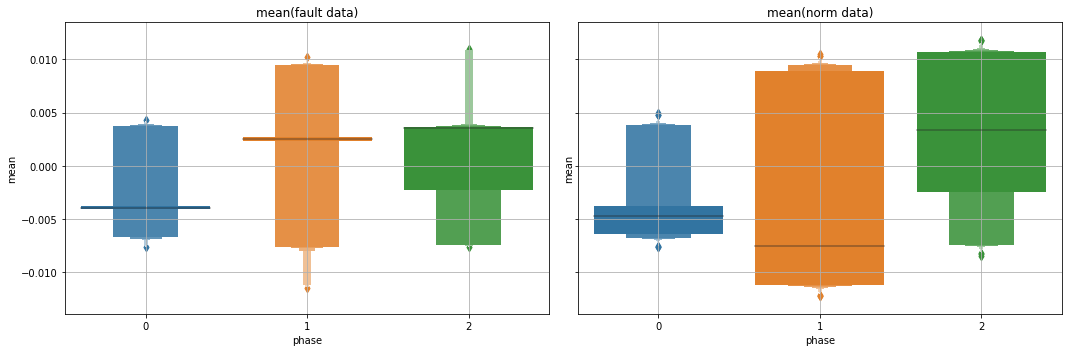

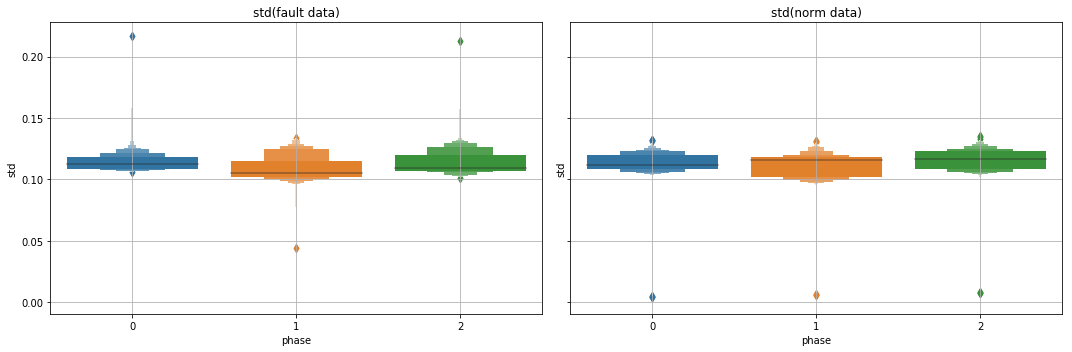

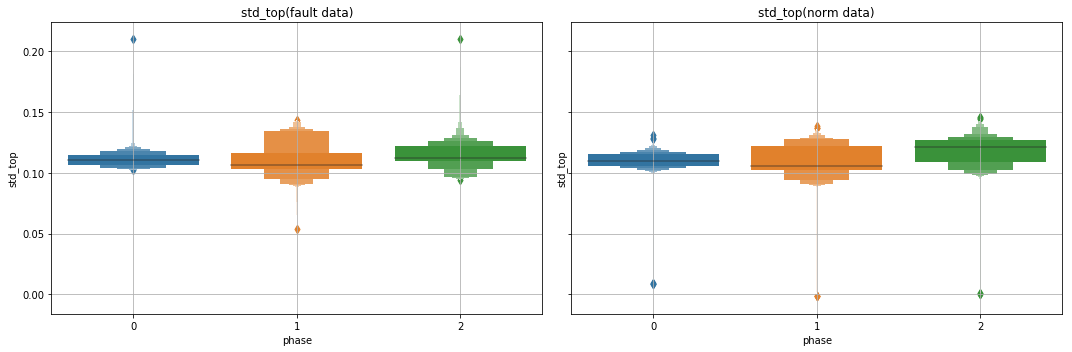

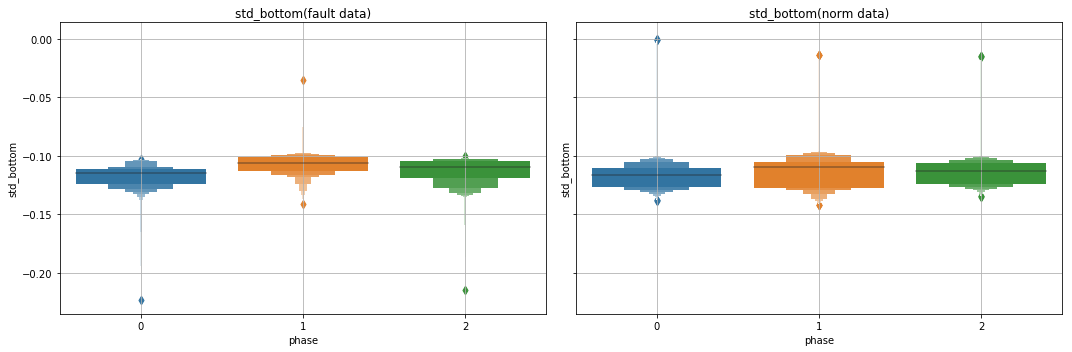

In [11]:
def p_fig_v2(f_data, n_data, target):
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
    axes = axes.flatten()
    sns.boxenplot(x='phase', y=target, data=f_data, linewidth=5, ax=axes[0])
    axes[0].set_title('{}(fault data)'.format(target))
    axes[0].grid(b=True)
    sns.boxenplot(x='phase', y=target, data=n_data, linewidth=5, ax=axes[1])
    axes[1].set_title('{}(norm data)'.format(target))
    axes[1].grid(b=True)
    fig.tight_layout()

p_fig_v2(f_new_df, norm_new_df, 'mean')
p_fig_v2(f_new_df, norm_new_df, 'std')
p_fig_v2(f_new_df, norm_new_df, 'std_top')
p_fig_v2(f_new_df, norm_new_df, 'std_bottom')

In [12]:
v_c = f_data.index.value_counts()
f_n = [] #Same Id_Measurement have fault data and normal data
#print(v_c)
for id, count in tqdm(zip(v_c.index, v_c.values)):
    if count < 3: f_n.append(id)
f_n.sort()
f_n = np.asarray(f_n)

def load_data(id_measure):
    targets = []
    signal = []
    for id in tqdm(id_measure):
        s_id = meta_train[meta_train.index == id].signal_id.values
        t = meta_train[meta_train.index == id].target.values
        s = np.asarray([min_max(pf_train_v[i]) for i in s_id])
        targets.extend(t)
        signal.append(s)
    
    signal = np.concatenate(signal)
    
    return np.asarray(signal), targets

s, t = load_data(f_n)

194it [00:00, 238900.46it/s]
100%|██████████| 38/38 [00:01<00:00, 30.12it/s]


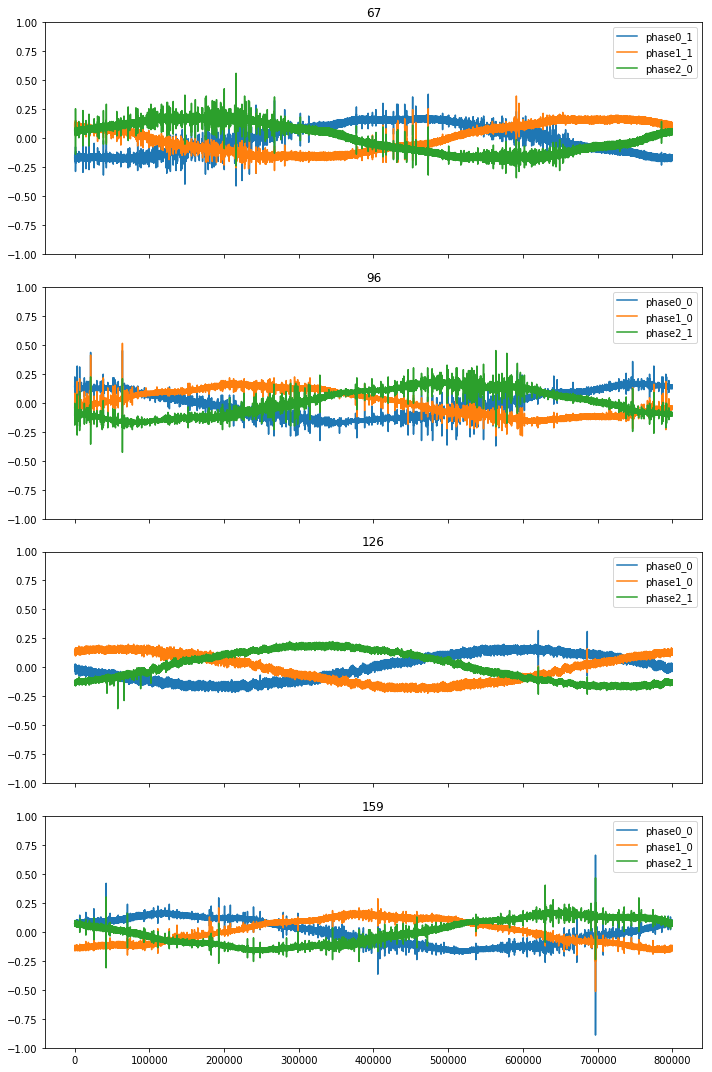

In [13]:
def p_fig_v3(data, ids, target, n_rows=None, size=120):
    #assert len(target) % 3 == 0
    if n_rows == None:
        n_rows = int(len(ids))        
    fig, axes = plt.subplots(n_rows, 1, sharex=True, figsize=(10, int(size/n_rows)))
    axes = axes.flatten()
    for i, (ax, idx) in enumerate(zip(axes, ids)):
        start = i*3
        ax.plot(data[start, :])
        ax.plot(data[start+1, :])
        ax.plot(data[start+2, :])
        ax.set_title(idx)
        ax.legend(['phase0_%s'%(target[start]), 'phase1_%s'%(target[start+1]), 'phase2_%s'%(target[start+2])])
        ax.set_ylim(bottom=-1.0, top=1.0)
    fig.tight_layout()
    
p_fig_v3(s[:12, :], f_n[:4], t[:12], size=60)